This version dropped body weight, and used both apsiii and oasis for PSM and regression analyses

Correction: AUC sld be roc_auc_score(y, **probas_**) NOT roc_auc_score(y, pred)

added apsiii and oasis in the covariate_table

https://medium.com/@bmiroglio/introducing-the-pymatch-package-6a8c020e2009

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from pymatch.Matcher import Matcher
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

In [2]:
df = pd.read_csv('./data/df_clean_0424_CVICU.csv')
df = df[df['hospital_expire_flag']==0]

print(df.shape)
df.head()

(285, 29)


,subject_id,los,hospital_expire_flag,expose,age,gender,heart_rate_first24h_mean,mbp_first24h_mean,resp_rate_first24h_mean,spo2_first24h_mean,...,heart_rhythm_first24h_firstRecorded,heart_rhythm_first24h_numTypeRecorded,charlson_comorbidity_index,lowest_gcs_motor_eyes_first24h,last_gcs_motor_eyes,last_gcs_motor,first_gcs_motor_eyes,apsiii,oasis,heart_rhythm_cat
2,10109956,14.0,0,1,62.34224,F,99.12245,86.67000,21.22917,97.57447,...,SR (Sinus Rhythm),2.0,10,2.0,10,6,2.0,86,52,SR (Sinus Rhythm)
3,10131457,11.0,0,0,41.21647,M,54.08333,90.55932,16.84167,99.33333,...,SB (Sinus Bradycardia),2.0,2,2.0,10,6,9.0,31,33,rare rhythm
5,10150911,7.0,0,1,58.80580,F,65.64286,88.43750,30.57143,94.88889,...,SB (Sinus Bradycardia),2.0,3,2.0,10,6,2.0,125,58,rare rhythm
6,10172206,13.0,0,1,61.34548,M,57.56522,77.84615,23.81250,99.47826,...,V Paced,1.0,8,2.0,10,6,6.0,98,47,rare rhythm
10,10246670,16.0,0,0,44.64849,M,77.91667,77.07143,18.42857,99.19048,...,SR (Sinus Rhythm),1.0,4,2.0,7,3,10.0,74,38,SR (Sinus Rhythm)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285 entries, 2 to 576
Data columns (total 29 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   subject_id                             285 non-null    int64  
 1   los                                    285 non-null    float64
 2   hospital_expire_flag                   285 non-null    int64  
 3   expose                                 285 non-null    int64  
 4   age                                    285 non-null    float64
 5   gender                                 285 non-null    object 
 6   heart_rate_first24h_mean               285 non-null    float64
 7   mbp_first24h_mean                      285 non-null    float64
 8   resp_rate_first24h_mean                285 non-null    float64
 9   spo2_first24h_mean                     285 non-null    float64
 10  heart_rate_first24h_max                285 non-null    float64
 11  mbp_fi

In [4]:
X = df.drop(['subject_id', 'los','hospital_expire_flag','expose',
    'mbp_first24h_mean', 'resp_rate_first24h_mean', 'spo2_first24h_mean',
    'mbp_first24h_min',  'resp_rate_first24h_min',  'spo2_first24h_min', 'heart_rate_first24h_min',
    'mbp_first24h_max',  'resp_rate_first24h_max',  'spo2_first24h_max', 'heart_rate_first24h_max',     
    'first_gcs_motor_eyes', 'last_gcs_motor_eyes', 'last_gcs_motor', 'heart_rhythm_first24h_firstRecorded', 'icu_entrydate_weekend',
    'heart_rhythm_first24h_numTypeRecorded'], axis=1)

X = pd.get_dummies(X, columns=['gender','heart_rhythm_cat'], drop_first=True)
y = df['expose']

In [5]:
X.columns

Index(['age', 'heart_rate_first24h_mean', 'charlson_comorbidity_index',
       'lowest_gcs_motor_eyes_first24h', 'apsiii', 'oasis', 'gender_M',
       'heart_rhythm_cat_SR (Sinus Rhythm)',
       'heart_rhythm_cat_ST (Sinus Tachycardia) ',
       'heart_rhythm_cat_rare rhythm'],
      dtype='object')

In [6]:
param_grid = {'max_depth': [1, 2, 5, 10, 15],
         'n_estimators': [10, 20, 30, 50, 100],
         'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2, 0.5]}

lgbm = GridSearchCV(lgb.LGBMClassifier(
    boosting_type='gbdt', n_jobs=-1, random_state=1),
    param_grid=param_grid, cv=5, n_jobs=-1,
    scoring='roc_auc', refit = True)
lgbm.fit(X, y)
lgbm.best_params_

{'learning_rate': 0.2, 'max_depth': 1, 'n_estimators': 100}

In [7]:
lgbm_pred = lgbm.predict(X)
lgbm_probas_ = lgbm.predict_proba(X)
print('Accuracy:',accuracy_score(y, lgbm_pred))
print('AUC:', roc_auc_score(y, lgbm_probas_[:,1]))

Accuracy: 0.7929824561403509
AUC: 0.8760869565217392


In [8]:
df['score'] = lgbm_probas_[:, 1]

In [10]:
excl_covariates = ['subject_id', 'los','hospital_expire_flag','score',
    'mbp_first24h_mean', 'resp_rate_first24h_mean', 'spo2_first24h_mean',
    'mbp_first24h_min',  'resp_rate_first24h_min',  'spo2_first24h_min', 'heart_rate_first24h_min',
    'mbp_first24h_max',  'resp_rate_first24h_max',  'spo2_first24h_max', 'heart_rate_first24h_max',
    'first_gcs_motor_eyes', 'last_gcs_motor_eyes','last_gcs_motor','heart_rhythm_first24h_firstRecorded', 'icu_entrydate_weekend',
    'heart_rhythm_first24h_numTypeRecorded']

test = df[df.expose==1]
control = df[df.expose==0]

m = Matcher(test, control, yvar="expose", exclude=excl_covariates)

Formula:
expose ~ age+gender+heart_rate_first24h_mean+charlson_comorbidity_index+lowest_gcs_motor_eyes_first24h+apsiii+oasis+heart_rhythm_cat
n majority: 170
n minority: 115


In [11]:
np.random.seed(1234)
m.fit_scores(balance=True, nmodels=100)
m.predict_scores()
# ignore the accuracy score

Fitting Models on Balanced Samples: 100\100
Average Accuracy: 75.59%


In [12]:
# lg_pred = np.where(m.data['scores']>=0.5,1,0)
print('AUC:', roc_auc_score(y, m.data['scores']))

AUC: 0.512531969309463


In [13]:
m.data['scores'] = m.data['score']
m.data = m.data.drop(['score'],axis=1)
print('Accuracy:',accuracy_score(y, lgbm_pred))

Accuracy: 0.7929824561403509


In [14]:
# rec threshold
thresh = np.std(m.data['scores'])*0.2
thresh

0.053414626132932824

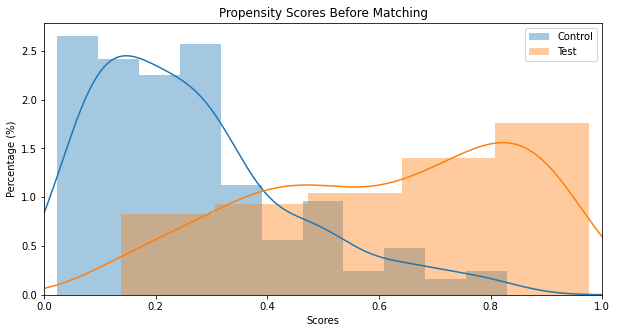

In [15]:
m.plot_scores()

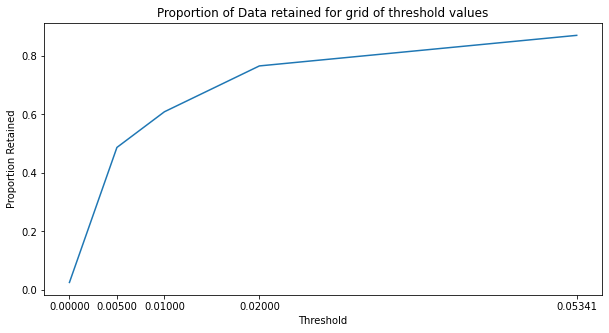

In [16]:
m.tune_threshold(method='random', rng=[0., 0.005, 0.01, 0.02, thresh])

In [17]:
m.match(method="random", nmatches=1, threshold=thresh)

In [18]:
m.record_frequency()

,freq,n_records
0,1,131
1,2,12
2,3,5
3,6,1
4,10,1
5,14,1


In [19]:
m.assign_weight_vector()

In [20]:
m.matched_data.sort_values("match_id").head(6)
m.matched_data.shape

(200, 33)

,var,before,after
0,gender,0.951754,0.554463
1,heart_rhythm_cat,0.311840,0.098242


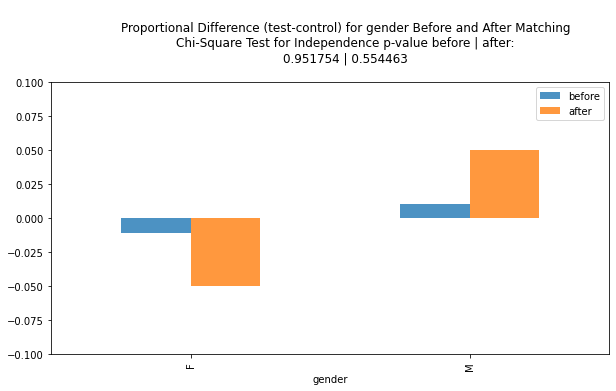

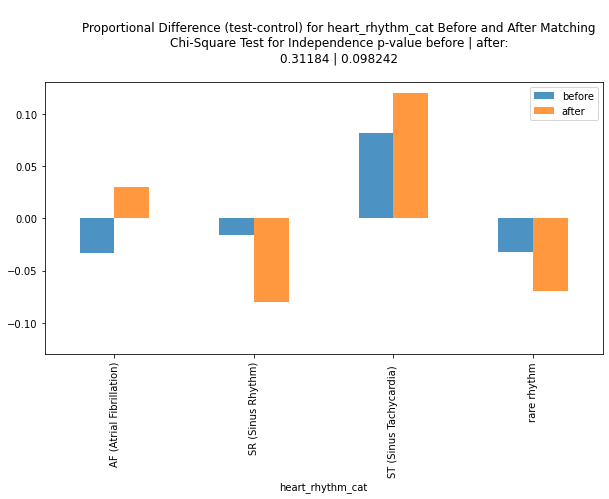

In [21]:
# compare before/after categorical features 
m.compare_categorical(return_table=True)

,var,ks_before,ks_after,grouped_chisqr_before,grouped_chisqr_after,std_median_diff_before,std_median_diff_after,std_mean_diff_before,std_mean_diff_after
0,age,0.003,0.086,0.005,0.074,-0.446666,0.300882,-0.455452,0.157214
1,heart_rate_first24h_mean,0.000,0.012,0.000,0.034,-0.708860,0.417245,-0.633474,0.176640
2,charlson_comorbidity_index,0.006,0.110,0.633,0.806,-0.362490,-0.337693,-0.294813,-0.155339
3,lowest_gcs_motor_eyes_first24h,0.001,0.010,1.000,1.000,0.000000,0.000000,-0.464227,-0.355148
4,apsiii,0.025,0.486,0.162,0.432,0.558992,-0.084794,0.370270,0.126851
5,oasis,0.054,0.111,0.400,0.003,0.498885,0.000000,0.248691,-0.187317


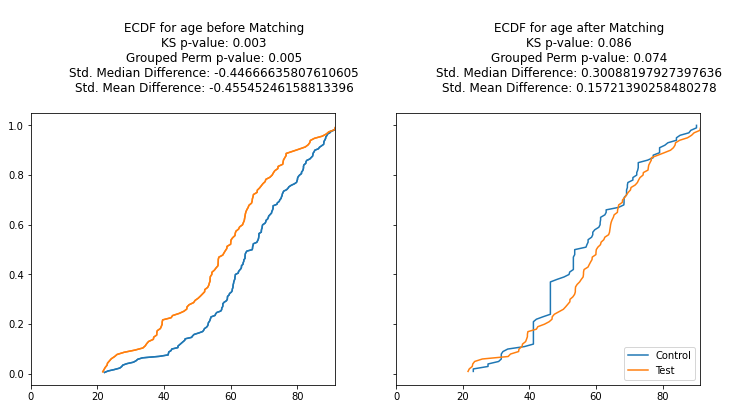

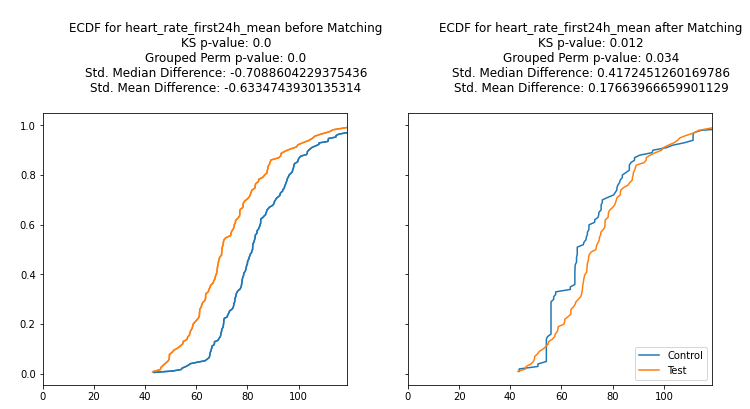

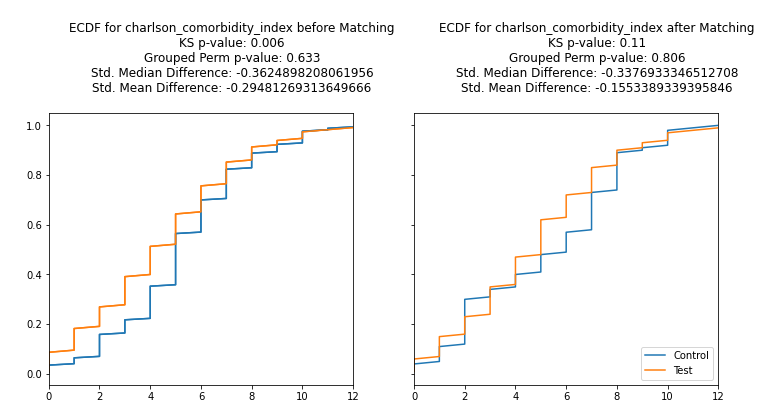

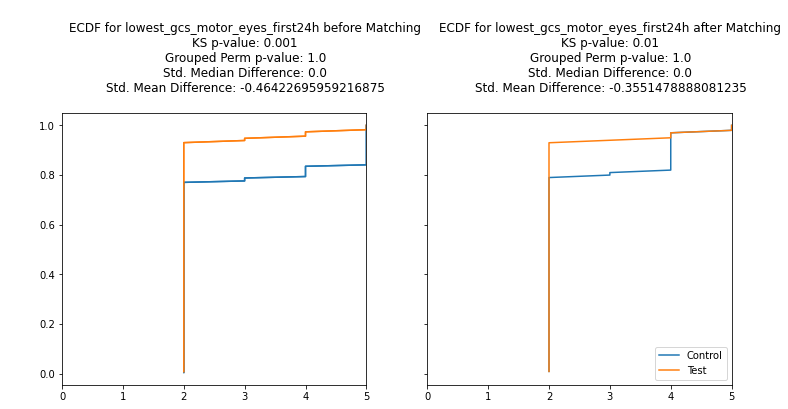

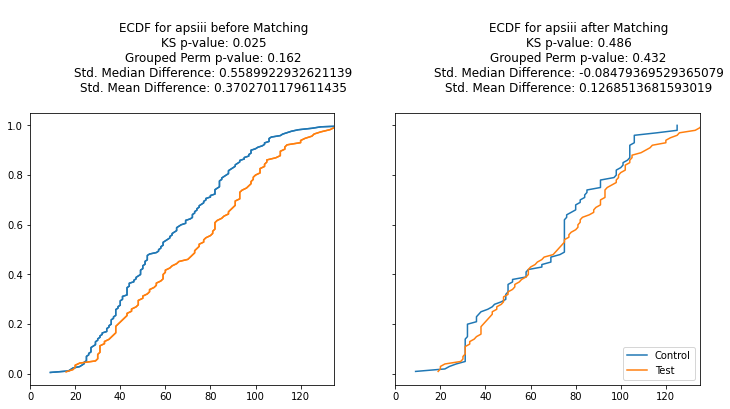

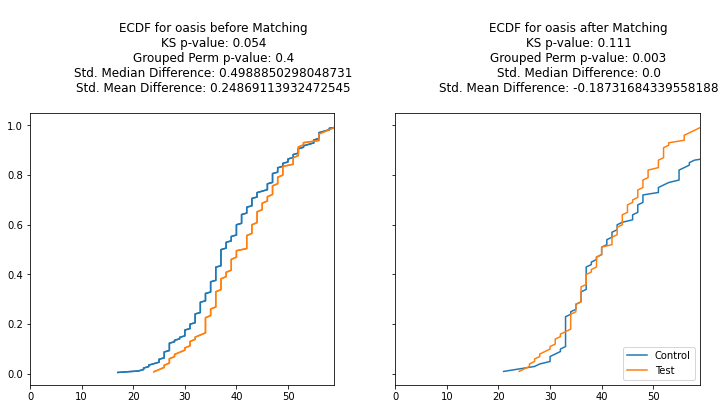

In [22]:
# compare before/after continuous features 
m.compare_continuous(return_table=True)

Increasing the number of untreated subjects matched to each treated subject tended to increase the bias in the estimated treatment effect; conversely, increasing the number of untreated subjects matched to each treated subject decreased the sampling variability of the estimated treatment effect. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2962254/

In [23]:
matched_1to1 = m.matched_data.sort_values("match_id")
matched_1to1.shape
matched_1to1['scores'].head()

0      0.183010
113    0.161693
1      0.787027
120    0.733992
2      0.840800
Name: scores, dtype: float64

In [24]:
# p = matched_1to1['scores']*matched_1to1['expose'] + (1-matched_1to1['scores'])*(1-matched_1to1['expose'])
# matched_1to1['ipw'] = 1 + np.exp(-np.log(p/(1-p)))
matched_1to1['ipw'] = 1+matched_1to1['scores']

matched_1to1['ipw_freq'] = matched_1to1['ipw']*matched_1to1['weight']
matched_1to1.shape

(200, 35)

In [25]:
matched_1to1.head()

,record_id,weight,subject_id,los,hospital_expire_flag,expose,age,gender,heart_rate_first24h_mean,mbp_first24h_mean,...,last_gcs_motor_eyes,last_gcs_motor,first_gcs_motor_eyes,apsiii,oasis,heart_rhythm_cat,scores,match_id,ipw,ipw_freq
0,0,1.000000,10109956,14.0,0,1,62.34224,F,99.12245,86.67000,...,10,6,2.0,86,52,SR (Sinus Rhythm),0.183010,0,1.183010,1.183010
113,118,1.000000,10495588,2.0,0,0,58.68197,F,68.53571,74.20833,...,10,6,5.0,58,28,SR (Sinus Rhythm),0.161693,0,1.161693,1.161693
1,1,1.000000,10150911,7.0,0,1,58.80580,F,65.64286,88.43750,...,10,6,2.0,125,58,rare rhythm,0.787027,1,1.787027,1.787027
120,137,0.166667,11841713,1.0,0,0,53.21026,F,65.22222,86.92683,...,10,6,2.0,32,37,SR (Sinus Rhythm),0.733992,1,1.733992,0.288999
2,2,1.000000,10172206,13.0,0,1,61.34548,M,57.56522,77.84615,...,10,6,6.0,98,47,rare rhythm,0.840800,2,1.840800,1.840800


In [26]:
from statsmodels.stats import weightstats as st
from statsmodels.stats import meta_analysis as mt

control = df[df['expose']==0]
treatment = df[df['expose']==1]

variables = [
    'age','heart_rate_first24h_mean','apsiii','oasis',
    'charlson_comorbidity_index', 'lowest_gcs_motor_eyes_first24h']

lst = []

for i in variables:
    row_fill = []
    row_fill.append(i)
    row_fill.append(np.mean(treatment[i]))
    row_fill.append(np.std(treatment[i]))
    row_fill.append(np.mean(control[i]))
    row_fill.append(np.std(control[i]))
    row_fill.append(abs(mt.effectsize_smd(row_fill[1],row_fill[2], treatment.shape[0],row_fill[3],row_fill[4],control.shape[0])[0]))
    t_value, p_value, degfree = st.ttest_ind(control[i],treatment[i],alternative="two-sided",usevar="pooled")
    row_fill.append(t_value)
    row_fill.append(p_value)
    lst.append(row_fill)

covariate_table = pd.DataFrame(lst, columns=['Variable Name', 'Exposure Mean', 'Exposure std', 'Non-Exposure Mean', 'Non-Exposure std', 'SMD','t-value', 'p-value'])

#covariate_table['p-value'] = covariate_table['p-value'].round(decimals=3)
covariate_table

,Variable Name,Exposure Mean,Exposure std,Non-Exposure Mean,Non-Exposure std,SMD,t-value,p-value
0,age,57.388563,17.606944,65.223307,16.174403,0.466055,3.856439,1.424820e-04
1,heart_rate_first24h_mean,73.231163,16.724158,83.931294,15.585610,0.664742,5.500567,8.470907e-08
2,apsiii,72.200000,30.817048,61.270588,27.749462,0.375563,-3.107612,2.077898e-03
3,oasis,41.260870,8.529322,39.017647,9.228137,0.249885,-2.067944,3.955382e-02
4,charlson_comorbidity_index,4.504348,2.911369,5.317647,2.599601,0.297179,2.459001,1.453107e-02
5,lowest_gcs_motor_eyes_first24h,2.147826,0.578506,2.605882,1.149409,0.475319,3.934760,1.048569e-04


In [ ]:
import scipy
print(scipy.stats.mannwhitneyu(treatment['heart_rhythm_cat'], control['heart_rhythm_cat']))
print(scipy.stats.mannwhitneyu(treatment['gender'], control['gender']))
print(scipy.stats.mannwhitneyu(treatment['icu_entrydate_weekend'], control['icu_entrydate_weekend']))

In [ ]:
control.shape

In [ ]:
from statsmodels.stats import weightstats as st

control = matched_1to1[matched_1to1['expose']==0]
treatment = matched_1to1[matched_1to1['expose']==1]

variables = [
    'age','heart_rate_first24h_mean',
    'charlson_comorbidity_index', 'lowest_gcs_motor_eyes_first24h']

lst = []

for i in variables:
    row_fill = []
    row_fill.append(i)
    row_fill.append(np.mean(treatment[i]))
    row_fill.append(np.std(treatment[i]))
    row_fill.append(np.mean(control[i]))
    row_fill.append(np.std(control[i]))
    row_fill.append(abs(row_fill[1]-row_fill[3]))
    row_fill.append(abs(mt.effectsize_smd(row_fill[1],row_fill[2], treatment.shape[0],row_fill[3],row_fill[4],control.shape[0])[0]))
    t_value, p_value, degfree = st.ttest_ind(control[i],treatment[i],alternative="two-sided",usevar="pooled", weights=(control['weight'], treatment['weight']))
    row_fill.append(t_value)
    row_fill.append(p_value)
    lst.append(row_fill)

covariate_table = pd.DataFrame(lst, columns=['Variable Name', 'Exposure Mean', 'Exposure std', 'Non-Exposure Mean', 'Non-Exposure std', 'Mean Difference', 'SMD','t-value', 'p-value'])

covariate_table['p-value'] = covariate_table['p-value'].round(decimals=3)
covariate_table

In [ ]:
control.shape

In [ ]:
import scipy
print(scipy.stats.mannwhitneyu(treatment['heart_rhythm_cat'], control['heart_rhythm_cat']))
print(scipy.stats.mannwhitneyu(treatment['gender'], control['gender']))
print(scipy.stats.mannwhitneyu(treatment['icu_entrydate_weekend'], control['icu_entrydate_weekend']))

In [ ]:
#matched_1to1.to_csv('matched_1to1_lgbm_0415.csv', index=False)

# Statistical Analysis

In [26]:
matched_1to1['binary_last_gcs'] = np.where(matched_1to1['last_gcs_motor']<6,1,0)

In [27]:
#df_los.iloc[30:40,:]

In [28]:
# GCS outcome
f = 'binary_last_gcs ~ expose + age + C(gender) + C(heart_rhythm_cat) + heart_rate_first24h_mean + mbp_first24h_mean + resp_rate_first24h_mean + spo2_first24h_mean  + charlson_comorbidity_index + lowest_gcs_motor_eyes_first24h + C(icu_entrydate_weekend) + apsiii + oasis'
res = smf.glm(f, data=matched_1to1, family=sm.families.Binomial(),
               freq_weights=matched_1to1['ipw_freq']).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:        binary_last_gcs   No. Observations:                  200
Model:                            GLM   Df Residuals:                   213.96
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -63.672
Date:                Mon, 25 Apr 2022   Deviance:                       127.34
Time:                        21:56:48   Pearson chi2:                     269.
No. Iterations:                    23   Pseudo R-squ. (CS):             0.2941
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                        -27.5486   2.82e+04     -0.001      0.999   -5.54e+04    5.53e+04
C(gender)[T.M]                                    -0.8604      0.518     -1.661      0.097      -1.876       0.155
C(heart_rhythm_cat)[T.SR (Sinus Rhythm)]          -1.6176      1.147     -1.410      0.159      -3.866       0.631
C(heart_rhythm_cat)[T.ST (Sinus Tachycardia) ]    -0.9341      1.155     -0.809      0.419      -3.198       1.329
C(heart_rhythm_cat)[T.rare rhythm]                -1.6738      1.219     -1.373      0.170      -4.063       0.716
C(icu_entrydate_weekend)[T.True]                  -1.0165      0.572     -1.778      0.075      -2.137       0.104
expose                                             1.0675      0.674      1.583      0.113      -0.254       2.389
age                                                0.0451      0.022      2.009      0.045       0.001       0.089
heart_rate_first24h_mean                           0.0472      0.022      2.149      0.032       0.004       0.090
mbp_first24h_mean                                  0.0369      0.020      1.846      0.065      -0.002       0.076
resp_rate_first24h_mean                           -0.0137      0.065     -0.211      0.833      -0.141       0.114
spo2_first24h_mean                                 0.5762      0.192      2.994      0.003       0.199       0.953
charlson_comorbidity_index                        -0.3293      0.135     -2.438      0.015      -0.594      -0.065
lowest_gcs_motor_eyes_first24h                   -20.5167   1.41e+04     -0.001      0.999   -2.77e+04    2.77e+04
apsiii                                             0.0260      0.011      2.283      0.022       0.004       0.048
oasis                                              0.0419      0.044      0.955      0.340      -0.044       0.128
==================================================================================================================
"""

In [29]:
odds_ratios = pd.DataFrame(
    {
        "OR": res.params,
        "Lower CI": res.conf_int()[0],
        "Upper CI": res.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)
odds_ratios

,OR,Lower CI,Upper CI
Intercept,1.085919e-12,0.000000,inf
C(gender)[T.M],4.229830e-01,0.153275,1.167278
C(heart_rhythm_cat)[T.SR (Sinus Rhythm)],1.983707e-01,0.020935,1.879644
C(heart_rhythm_cat)[T.ST (Sinus Tachycardia) ],3.929355e-01,0.040862,3.778537
C(heart_rhythm_cat)[T.rare rhythm],1.875299e-01,0.017192,2.045523
C(icu_entrydate_weekend)[T.True],3.618741e-01,0.118038,1.109410
expose,2.908237e+00,0.775830,10.901664
age,1.046130e+00,1.001096,1.093189
heart_rate_first24h_mean,1.048318e+00,1.004168,1.094410
mbp_first24h_mean,1.037573e+00,0.997724,1.079014
